In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
# ---- USER CONFIG ----
csv_dir = "./data/analysis/results/"                    
top_k = 5                         # how many top gaps to show/plot
save_ranked_csv = "ranked_gaps.csv"
# ----------------------


all_csvs = glob.glob(os.path.join(csv_dir, "*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSVs found in {csv_dir}")
def pick_candidate(substr, files):
    cand = [f for f in files if substr.lower() in os.path.basename(f).lower()]
    if not cand:
        return None
    # return the most likely: if multiple, prefer the one with 'untargeted' or shortest name
    cand = sorted(cand, key=lambda x: (('untargeted' in x.lower()) == False, len(x)))
    return cand[0]
# locate the three types
f_routed = pick_candidate("advlogifold_routed", all_csvs)
f_comm = pick_candidate("logifold_committees_experts", all_csvs)
f_baseline = pick_candidate("baseline_single_models", all_csvs)

all_routed = [f for f in all_csvs if "advlogifold_routed" in os.path.basename(f).lower()]
all_comm = [f for f in all_csvs if "logifold_committees_experts" in os.path.basename(f).lower()]
all_baseline = [f for f in all_csvs if "baseline_single_models" in os.path.basename(f).lower()]

# Load
df_cand_routed = pd.read_csv(f_routed)
df_cand_comm = pd.read_csv(f_comm)
df_cand_base = pd.read_csv(f_baseline)

# Inspect columns (quick)
print("\nColumns (routed):", df_cand_routed.columns.tolist())
print("Columns (Not-routed):", df_cand_comm.columns.tolist())
print("Columns (baseline):", df_cand_base.columns.tolist())
print(all_routed)
print(all_comm)
print(all_baseline)

In [ ]:
single_model_results = all_baseline[0]

df_single_model_results = pd.read_csv(single_model_results)
print(df_single_model_results)



In [ ]:
import re
def canonize_model(name: str) -> str:
    name = name.strip()
    name = name.lower()
    return re.sub(r"_ver\d+$", "", name)
df = df_single_model_results.copy()
df["canon_model"] = df["model"].map(canonize_model)

# 2) Average accuracy across versions for each (canon_model, dataset)
avg_df = (
    df.groupby(["canon_model", "dataset"], as_index=False)["accuracy"]
      .mean()
      .rename(columns={"accuracy": "avg_accuracy"})
)

# (Optional) Also get count of versions aggregated, for transparency
cnt_df = (
    df.groupby(["canon_model", "dataset"], as_index=False)["accuracy"]
      .size()
      .rename(columns={"size": "n_versions"})
)

avg_df = avg_df.merge(cnt_df, on=["canon_model", "dataset"], how="left")

# 3) If you need the single best averaged model per dataset:
best_per_dataset = (
    avg_df.sort_values(["dataset", "avg_accuracy"], ascending=[True, False])
          .groupby("dataset", as_index=False)
          .first()
)

# Show results
print("Averaged across versions (per canon_model, dataset):")
print(avg_df.sort_values(["dataset", "canon_model"]).to_string(index=False))

print("\nBest averaged single-model per dataset:")
print(best_per_dataset[["dataset", "canon_model", "avg_accuracy", "n_versions"]]
      .to_string(index=False))

In [ ]:
def _gen_family(gen: str) -> str:
    g = gen.lower()
    if g.startswith("resnet"):
        return "resnet"
    if g.startswith("vgg"):
        return "vgg"
    return "other"
def _mode_token(mode: str) -> str:
    # map 'targeted-to-2nd'/'targeted-to-least'/'untargeted' -> ('2nd'|'least'|'')
    if "to-2nd" in mode:  return "2nd"
    if "to-least" in mode: return "least"
    if "untargeted" in mode: return ""
    return ""  # default

def _pgd_scale_from(name: str) -> str:
    # "eps216-iter96-8steps" -> 'big',  "eps8-iter2-10steps" -> 'std'
    if "eps216" in name: return "big"
    if "eps8"  in name: return "std"
    return ""



In [ ]:
def simplify_testing_dataset(s: str) -> dict:
    """
    Returns dict with:
      attack: cwl2|pgd|fgm|deepfool|original
      mode: ''|'2nd'|'least'
      pgd_scale: ''|'big'|'std'
      generator: raw generator token (e.g., 'resnet56v1-ver0')
      generator_family: 'resnet'|'vgg'|'other'
      simple_label: your requested compact label
    """
    s = s.strip()
    if s == "original":
        return dict(attack="original", mode="", pgd_scale="", generator="",
                    generator_family="", simple_label="original")
    # Extract trailing generator "...-by-<GEN>-verX"
    gen = ""
    m_gen = re.search(r"-by-([a-zA-Z0-9]+(?:[a-zA-Z0-9]*))-(ver\d+)$", s)
    if m_gen:
        gen = f"{m_gen.group(1)}-{m_gen.group(2)}"
        genfam = _gen_family(m_gen.group(1))
    else:
        genfam = ""

    # Identify attack family
    if s.startswith("cwl2"):
        # cwl2-(targeted-to-2nd|targeted-to-least|untargeted)-by-...
        mode = _mode_token(s)
        if mode == "2nd":
            label = "cwl2(2nd)"
        elif mode == "least":
            label = "cwl2(least)"
        else:
            label = "cwl2"
        return dict(attack="cwl2", mode=mode, pgd_scale="", generator=gen,
                    generator_family=genfam, simple_label=label)

    if s.startswith("deepfool"):
        # deepfool-untargeted-...
        return dict(attack="deepfool", mode="", pgd_scale="", generator=gen,
                    generator_family=genfam, simple_label="DF")

    if s.startswith("fgm"):
        # fgm-eps216-(targeted-to-2nd|targeted-to-least|untargeted)-by-...
        mode = _mode_token(s)
        if mode == "2nd":
            label = "fgm(2nd)"
        elif mode == "least":
            label = "fgm(least)"
        else:
            label = "fgm"
        return dict(attack="fgm", mode=mode, pgd_scale="", generator=gen,
                    generator_family=genfam, simple_label=label)

    if s.startswith("pgd"):
        # pgd-<eps...>-<iter...>-<steps...>-(targeted-to-2nd|targeted-to-least|untargeted)-by-<GEN>-verX
        mode = _mode_token(s)
        scale = _pgd_scale_from(s)
        # Build label like pgd(least, big) or pgd(2nd, std) or pgd(big) for untargeted
        if mode:
            label = f"pgd({mode}, {scale})"
        else:
            label = f"pgd({scale})" if scale else "pgd"
        return dict(attack="pgd", mode=mode, pgd_scale=scale, generator=gen,
                    generator_family=genfam, simple_label=label)

    # Fallback
    return dict(attack="other", mode="", pgd_scale="", generator=gen,
                generator_family=genfam, simple_label=s)

In [ ]:
def add_parsed_cols(df: pd.DataFrame, col="testing_dataset") -> pd.DataFrame:
    parsed = df[col].map(simplify_testing_dataset)
    # explode the dict into columns
    extra = pd.DataFrame(list(parsed))
    out = pd.concat([df.copy(), extra], axis=1)
    return out

In [ ]:
def summarize_by_label_and_family(df: pd.DataFrame) -> pd.DataFrame:
    needed = [
        "simple_label", "generator_family",
        "refined_voting_by_all",
        "average_voting_by_Judges",
        "simple_majority_voting_by_Judges",
        'simple_majority_voting_by_all',
        'average_voting_by_all',
    ]
    
    avail = [c for c in needed if c in df.columns]
    agg = (df[avail]
           .groupby(["simple_label", "generator_family"], as_index=False)
           .mean(numeric_only=True))
    agg["Adv - judges_avg"] = agg["Adv_using_history"] - agg["average_voting_by_Judges"]
    agg["Adv - All_avg"] = agg["Adv_using_history"] - agg["average_voting_by_all"]
    agg["Adv - judges_majority"] = agg["Adv_using_history"] - agg["simple_majority_voting_by_Judges"]
    agg["Adv - All_majority"] = agg["Adv_using_history"] - agg["simple_majority_voting_by_all"]
    return agg

In [ ]:
def summarize_by_label_overall(df: pd.DataFrame) -> pd.DataFrame:
    cols = [
        "simple_label",
        "Adv_using_history",
        "average_voting_by_Judges",
    ]
    agg = (df[cols]
           .groupby("simple_label", as_index=False)
           .mean(numeric_only=True))
    agg["gap_hist_minus_judges_avg"] = agg["Adv_using_history"] - agg["average_voting_by_Judges"]
    return agg

In [ ]:
summarize_by_label_and_family(add_parsed_cols(df))

In [ ]:
def focal(focus: str = "Adv - judges_avg"):
    if focus not in ["Adv - judges_avg", "Adv - All_avg", "Adv - judges_majority", "Adv - All_majority"]:
        raise ValueError(f"focus must be one of 'Adv - judges_avg', 'Adv - All_avg', 'Adv - judges_majority', 'Adv - All_majority'")
    base_cols = ["simple_label", "generator_family", "Adv_using_history"]
    if focus == "Adv - judges_avg":
        return base_cols + ["average_voting_by_Judges", "Adv - judges_avg"]
    if focus == "Adv - All_avg":
        return base_cols + ["average_voting_by_all", "Adv - All_avg"]
    if focus == "Adv - judges_majority":
        return base_cols + ["simple_majority_voting_by_Judges", "Adv - judges_majority"]
    if focus == "Adv - All_majority":
        return base_cols + ["simple_majority_voting_by_all", "Adv - All_majority"]

In [ ]:
focus = "Adv - judges_avg"  
# or "Adv - All_avg" 
# or "Adv - judges_majority" 
# or "Adv - All_majority"

In [ ]:
# Example: pick PGD standard targeted-to-least
f_routed = "./data/analysis/results/advlogifold_routed_experts-PGD_standard_targeted-to-least.csv"
f_comm   = "./data/analysis/results/logifold_committees_experts-PGD_standard_targeted-to-least.csv"

df_routed = pd.read_csv(f_routed)
df_comm   = pd.read_csv(f_comm)

# 1. Grab the fixed entropy threshold
entropy_threshold = df_routed["entropy_threshold"].iloc[0]

# 2. Keep only the columns we care about
df_routed_sel = df_routed[["testing_dataset", "using_val_history_by_all"]].copy()
cols = list(df_comm.columns)
cols.remove('using_val_history_by_all')
cols.remove('using_val_history_by_Judges')
df_comm_sel   = df_comm[cols].copy()  

# 3. Merge on dataset
df = pd.merge(df_routed_sel, df_comm_sel, on="testing_dataset", suffixes=("_routed", "_comm"))

# 4. Compute differences vs Judges (all four options)
for col in ["simple_majority_voting_by_Judges", 
            "weighted_voting_by_Judges", 
            "average_voting_by_Judges"]:
    df[f"diff_vs_{col}"] = df["using_val_history_by_all"] - df[col]

# 5. If multiple rows per testing_dataset exist, average them
df_avg = df.groupby("testing_dataset", as_index=False).mean(numeric_only=True)

# 6. Sort by the largest positive gap vs Judges’ simple average


print("Entropy threshold used:", entropy_threshold)


summary_df = summarize_by_label_and_family(add_parsed_cols(df))
summary_df_sorted = summary_df.sort_values(focus, ascending=False)
summary_df_sorted[focal(focus)]



In [ ]:
# map suffix key e.g. "PGD_standard_targeted-to-least"
def key_from_path(p: str, routed=True) -> str:
    base = os.path.basename(p)
    if routed:
        # advlogifold_routed_experts-<KEY>.csv
        m = re.match(r"advlogifold_routed_experts-(.+)\.csv$", base)
    else:
        # logifold_committees_experts-<KEY>.csv
        m = re.match(r"logifold_committees_experts-(.+)\.csv$", base)
    return m.group(1) if m else None




In [ ]:

comm_index = { key_from_path(p, routed=False): p for p in all_comm }
# choose your focus metric to sort/print
all_results = []  # collect for one big dataframe

for f_routed in all_routed:
    key = key_from_path(f_routed, routed=True)
    f_comm = comm_index.get(key)
    if not key or not f_comm:
        # If no exact match, skip (keys differ like PGD_VGG vs PGD_standard, etc.)
        continue

    df_routed = pd.read_csv(f_routed)
    df_comm   = pd.read_csv(f_comm)
    cols = list(df_comm.columns)
    cols.remove('using_val_history_by_all')
    cols.remove('using_val_history_by_Judges')
    df_comm_sel   = df_comm[cols].copy()  
    # entropy (fixed in each routed file)
    entropy_threshold = df_routed["entropy_threshold"].iloc[0] if "entropy_threshold" in df_routed.columns else None

    # select & merge
    df_routed_sel = df_routed[["testing_dataset", "using_val_history_by_all"]].copy()
    df_routed_sel = df_routed_sel.rename(columns={"using_val_history_by_all": "Adv_using_history"})
    df = pd.merge(df_routed_sel, df_comm_sel, on="testing_dataset", how="inner")

    df = add_parsed_cols(df)
    summary = summarize_by_label_and_family(df)

    

    # sort for display
    summary_sorted = summary.sort_values(focus, ascending=False, na_position="last")

    # ------- PRINT -------
    print(f"\n=== {key} ===")
    looking_at = ['simple_label', 
                    'generator_family', 
                    'Adv_using_history', 
                    #  'average_voting_by_Judges', 
                    #  'simple_majority_voting_by_Judges', 
                    #  'simple_majority_voting_by_all',
                    #  'average_voting_by_all', 
                    'Adv - judges_avg', 
                    'Adv - All_avg', 
                    'Adv - judges_majority', 
                    'Adv - All_majority']
    print(f"entropy_threshold = {entropy_threshold}")
    fmt = {c: "{:.3f}".format for c in ['Adv - judges_avg', 
                                        'Adv - All_avg', 
                                        'Adv - judges_majority', 
                                        'Adv - All_majority']}
    fmt.update({'Adv_using_history' : "{:.4f}".format})
    print(summary_sorted[looking_at].to_string(index=False,formatters=fmt))
    # keep key/threshold in the table
    summary.insert(0, "logifold_type", key)
    summary.insert(1, "entropy_threshold", entropy_threshold)
    all_results.append(summary)

# if all_results:
#     combined = pd.concat(all_results, ignore_index=True)
#     combined = combined.sort_values(["logifold_type", focus], ascending=[True, False])
    #     combined.to_csv("./all_logifold_summaries.csv", index=False)
    #     print("\nSaved: ./all_logifold_summaries.csv")

In [ ]:
import matplotlib.pyplot as plt
def plot_table(summary_sorted, key, top_n=10, outdir="./plots"):
    os.makedirs(outdir, exist_ok=True)
    cols = ["simple_label", "generator_family", "Adv_using_history", "Adv - judges_avg"]
    tab = summary_sorted[cols].head(top_n).copy()
    tab["Adv_using_history"] = tab["Adv_using_history"].round(4)
    tab["Adv - judges_avg"] = tab["Adv - judges_avg"].round(3)
    tab.insert(0, "label", tab["simple_label"] + " \u2022 " + tab["generator_family"])
    tab = tab.drop(columns=["simple_label", "generator_family"])

    fig, ax = plt.subplots(figsize=(8, 0.4*len(tab) + 1))
    ax.axis("off")
    tbl = ax.table(cellText=tab.values,
                   colLabels=tab.columns,
                   loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.2)
    plt.title(f"Top {len(tab)} — {key}")
    # out_png = os.path.join(outdir, f"table_{re.sub(r'[^A-Za-z0-9_.-]+','_',key)}.png")
    # plt.savefig(out_png, dpi=200, bbox_inches="tight")
    # print(f"Saved plot: {out_png}")
    
    plt.show()
    plt.close()

In [ ]:
plot_table(summary_sorted, key = '')

In [ ]:
combined = pd.concat(all_results, ignore_index=True)
focus = "Adv - judges_avg"
types = combined["logifold_type"].unique().tolist()
cols = 2
rows = int(np.ceil(len(types) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.ravel()

for ax, key in zip(axes, types):
    sub = combined[combined["logifold_type"] == key] \
                 .sort_values(focus, ascending=False) 
    labels = np.where(
                    sub["generator_family"] == "resnet",
                    sub["simple_label"],
                    sub["simple_label"] + " \u2022 " + sub["generator_family"]
                ).tolist()
    vals = sub[focus].values
    y = np.arange(len(vals))
    ax.barh(y, vals)
    ax.invert_yaxis()
    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel("Adv_using_history - Judges average")
    ax.set_title(key, fontsize=11)
    for i, v in enumerate(vals):
        ax.text(v + (0.002 if v >= 0 else -0.002),
                i, f"{v:.3f}", va="center",
                ha="left" if v >= 0 else "right", fontsize=8)

# hide any extra axes
for j in range(len(types), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
# plt.savefig("./plots/gaps_small_multiples.png", dpi=200)
# print("Saved plot: ./plots/gaps_small_multiples.png")
plt.show()


In [ ]:
import os, re, numpy as np, matplotlib.pyplot as plt

FOCUS_COLS = ["Adv - judges_avg", "Adv - All_avg"]  # add more if you want

def plot_grouped_gaps(summary_sorted, key, top_n=10, outdir="./plots"):
    os.makedirs(outdir, exist_ok=True)

    sub = summary_sorted.copy()

    # ----- labels (conditional family suffix) -----
    labels = np.where(
        sub["generator_family"] == "resnet",
        sub["simple_label"],
        sub["simple_label"] + " \u2022 " + sub["generator_family"]
    ).tolist()

    # ----- values matrix (N x M) for grouped bars -----
    vals = sub[FOCUS_COLS].values  # shape: (N, 2)
    N, M = vals.shape

    # ----- bar positions -----
    y = np.arange(N)
    bar_gap = 0.35           # thickness of each bar group lane
    bar_height = bar_gap / M # height of each bar in the group
    offsets = (np.arange(M) - (M-1)/2.0) * (bar_height * 1.2)  # small spacing between the grouped bars

    # ----- plot -----
    plt.figure(figsize=(10, max(4, 0.5*N + 1)))
    for j in range(M):
        bj = plt.barh(y + offsets[j], vals[:, j], height=bar_height, label=FOCUS_COLS[j])
        # annotate values at the RIGHT of each bar
        for i, rect in enumerate(bj):
            v = vals[i, j]
            x = rect.get_width()
            yy = rect.get_y() + rect.get_height()/2
            # pad slightly to the right (or left if negative)
            pad = 0.002 if v >= 0 else -0.002
            ha = "left" if v >= 0 else "right"
            plt.text(x + pad, yy, f"{v:.3f}", va="center", ha=ha, fontsize=9, clip_on=False)

    plt.yticks(y, labels)
    plt.xlabel("Gap vs. committee baselines")
    plt.title(f"Gaps by dataset label — {key}")
    plt.axvline(0, linewidth=0.8)  # zero line for reference
    plt.legend(title="Metric", loc="best")
    plt.tight_layout()

    safe_key = re.sub(r"[^A-Za-z0-9_.-]+", "_", key)
    out_png = os.path.join(outdir, f"gaps_grouped_{safe_key}.png")
    plt.savefig(out_png, dpi=200)
    print(f"Saved plot: {out_png}")
    plt.show()
    plt.close()
    
    

In [ ]:
plot_grouped_gaps(summary_sorted, '')

In [ ]:

comm_index = { key_from_path(p, routed=False): p for p in all_comm }
# choose your focus metric to sort/print
all_results = []  # collect for one big dataframe

for f_routed in all_routed:
    key = key_from_path(f_routed, routed=True)
    f_comm = comm_index.get(key)
    if not key or not f_comm:
        # If no exact match, skip (keys differ like PGD_VGG vs PGD_standard, etc.)
        continue

    df_routed = pd.read_csv(f_routed)
    df_comm   = pd.read_csv(f_comm)
    cols = list(df_comm.columns)
    cols.remove('using_val_history_by_all')
    cols.remove('using_val_history_by_Judges')
    df_comm_sel   = df_comm[cols].copy()  
    # entropy (fixed in each routed file)
    entropy_threshold = df_routed["entropy_threshold"].iloc[0] if "entropy_threshold" in df_routed.columns else None

    # select & merge
    df_routed_sel = df_routed[["testing_dataset", "using_val_history_by_all"]].copy()
    df_routed_sel = df_routed_sel.rename(columns={"using_val_history_by_all": "Adv_using_history"})
    df = pd.merge(df_routed_sel, df_comm_sel, on="testing_dataset", how="inner")

    df = add_parsed_cols(df)
    summary = summarize_by_label_and_family(df)

    

    # sort for display
    summary_sorted = summary.sort_values(focus, ascending=False, na_position="last")

    # ------- PRINT -------
    print(f"\n=== {key} ===")
    looking_at = ['simple_label', 
                    'generator_family', 
                    'Adv_using_history', 
                    #  'average_voting_by_Judges', 
                    #  'simple_majority_voting_by_Judges', 
                    #  'simple_majority_voting_by_all',
                    #  'average_voting_by_all', 
                    'Adv - judges_avg', 
                    'Adv - All_avg', 
                    'Adv - judges_majority', 
                    'Adv - All_majority']
    print(f"entropy_threshold = {entropy_threshold}")
    fmt = {c: "{:.3f}".format for c in ['Adv - judges_avg', 
                                        'Adv - All_avg', 
                                        'Adv - judges_majority', 
                                        'Adv - All_majority']}
    fmt.update({'Adv_using_history' : "{:.4f}".format})
    print(summary_sorted[looking_at].to_string(index=False,formatters=fmt))
    # keep key/threshold in the table
    plot_grouped_gaps(summary_sorted, key)
    summary.insert(0, "logifold_type", key)
    summary.insert(1, "entropy_threshold", entropy_threshold)
    all_results.append(summary)
    
if all_results:
    combined = pd.concat(all_results, ignore_index=True)
    combined = combined.sort_values(["logifold_type", focus], ascending=[True, False])
    combined.to_csv("./data/analysis/results/all_logifold_summaries.csv", index=False)
    print("\nSaved: ./data/analysis/results/all_logifold_summaries.csv")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
resnet20v1_original_tuned-once-on_original_ver6_specialized-once-on_high-entropy-union-of-original-and-cwl2-untargeted-gen-by-resnet56v1-ver0_ver0.history.json


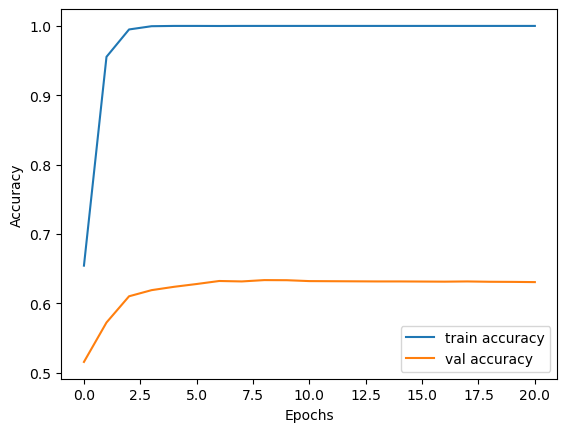

In [3]:
import json
from pathlib import Path
from matplotlib import pyplot as plt
specialized_model_paths = [
# 'resnet20v1_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-pgd-eps8-iter2-10steps-untargeted-gen-by-resnet56v1-ver0_ver0.history.json',
'resnet20v1_original_tuned-once-on_original_ver6_specialized-once-on_high-entropy-union-of-original-and-cwl2-untargeted-gen-by-resnet56v1-ver0_ver0.history.json',
# 'resnet20v2_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver6_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver1_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v2_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver1_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver7_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v2_original_tuned-once-on_original_ver1_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v2_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver4_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v2_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v2_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v2_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver5_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json'
# 'resnet56v1_original_tuned-once-on_original_ver3_specialized-once-on_stratified_high-entropy-union-of-original-and-cwl2-untargeted-gen-by-resnet56v1-ver0_ver0.history.json',
# 'resnet20v1_original_tuned-once-on_original_ver6_specialized-once-on_stratified_high-entropy-union-of-original-and-cwl2-untargeted-gen-by-resnet56v1-ver0_ver0.history.json',
 

]
for path in specialized_model_paths:
    print(path)
    # fp = Path(path)
    # name = fp.stem
    # name = str(name.split("_")[0])
    with open('./data/specialized_models/'+ path, "r") as f:
        obj = json.load(f)
    hist = obj.get("history", obj)
    plt.plot(hist['accuracy'], label='train accuracy')
    plt.plot(hist['val_accuracy'], label='val accuracy')
    # plt.title(f'Accuracy of Adversarially trained ResNet56v1 (tuned once)\non {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()